#### Boisset et al Bone Marrow Experiment

Micro-dissected: JC20, JC21,JC26, JC27, JC28, JC30, JC32, JC32, JC35, JC36, JC37,JC39, JC40,JC41,JC43,JC44,JC45,JC46,JC47

Sorted single cell: JC4, JC48P2,JC48P4, JC48P6, JC48P7

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
from matplotlib.transforms import Bbox
sys.path.append('../code/')


In [2]:
jc20 = pd.read_csv("/data/Alex/Boisset/GSE76983_expdata_BMJhscC.csv",sep="\t",header=0, index_col=0)
print (jc20.shape)

In [4]:
jc20 = jc20[jc20.sum(axis=1)>0]

In [5]:
sortedCells = jc20.filter(regex='JC4_|JC48P')

In [7]:
dissected = jc20.filter(regex="JC2._|JC3._|JC40_|JC41_|JC43_|JC44_|JC45_|JC46_|JC47_",axis=1)

In [9]:
sortedCells = sortedCells.T

In [10]:
sortedCells = sortedCells[sortedCells.sum(axis=1)>0]

In [11]:
sortedCells = sortedCells.T

In [12]:
singleCellLDA = VariationalLDA(K = 100,alpha = 1,eta=0.0005,update_alpha=True)

In [13]:
singleCellLDA.load_data_sc(sortedCells)

Edited


In [ ]:
singleCellLDA.run_vb(n_its = 1000,initialise=True)

In [ ]:
np.savetxt("betasBM.txt",singleCellLDA.beta_matrix, delimiter=",")

In [ ]:
betas_learned = pd.read_csv("betasBM.txt",sep=",",header=None)

In [ ]:
topic_dict = betas_learned.to_dict(orient='index')

In [ ]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

In [ ]:
scLDA.load_data_sc(dissected)

In [ ]:
scLDA.run_vb(n_its=1000,initialise=True)

In [288]:
print (scLDA.beta_matrix.shape)
print (singleCellLDA.get_expect_theta().shape)

(130, 15716)
(365, 100)


In [71]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=sortedCells.index)

In [336]:
def originalGenes (LDAObj,oldT,prob):
    oldgenes = []
    for t in range (0,oldT):
        td = LDAObj.get_topic_as_dict(t)
        for word, pb in td.items():
            if pb > prob:
                oldgenes.append(word)
    return oldgenes


def newGenes (LDAObj,oldT,prob):
    genes = []
    for t in range(oldT,LDAObj.beta_matrix.shape[0]):
        td = scLDA.get_topic_as_dict(t)
        for word, pb in td.items():
            if pb > prob:
                genes.append(word)
    return genes


def findIntGenes(originalG,newgenes):
    genes = []
    for g in newgenes: 
        if g not in originalG:
            genes.append(g)
    return genes
    
        
    

In [357]:
intGenes = findIntGenes(originalGenes(singleCellLDA,100,0.005),newGenes(scLDA,100,0.005))

In [366]:
wordTopic = pd.DataFrame(scLDA.beta_matrix, columns=sortedCells.index)

In [367]:
wordTopic = wordTopic.T

In [368]:
wordTopic.index = [a.split("_")[0] for a in list(wordTopic.index)]

In [369]:
wordTopic = wordTopic.T

In [370]:
intGenes = [a.split("_")[0] for a in list(set(intGenes))]

In [371]:
allGenes = [a.split("_")[0] for a in list(set(sortedCells.index))]

In [372]:
all_cells = pd.concat([sortedCells,dissected],axis=1)

In [373]:
colours = ['green' if x in sortedCells.columns else 'purple' for x in all_cells.columns]

In [374]:
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=all_cells.index)

In [375]:
all_cells.index = [a.split("_")[0] for a in list(all_cells.index)]

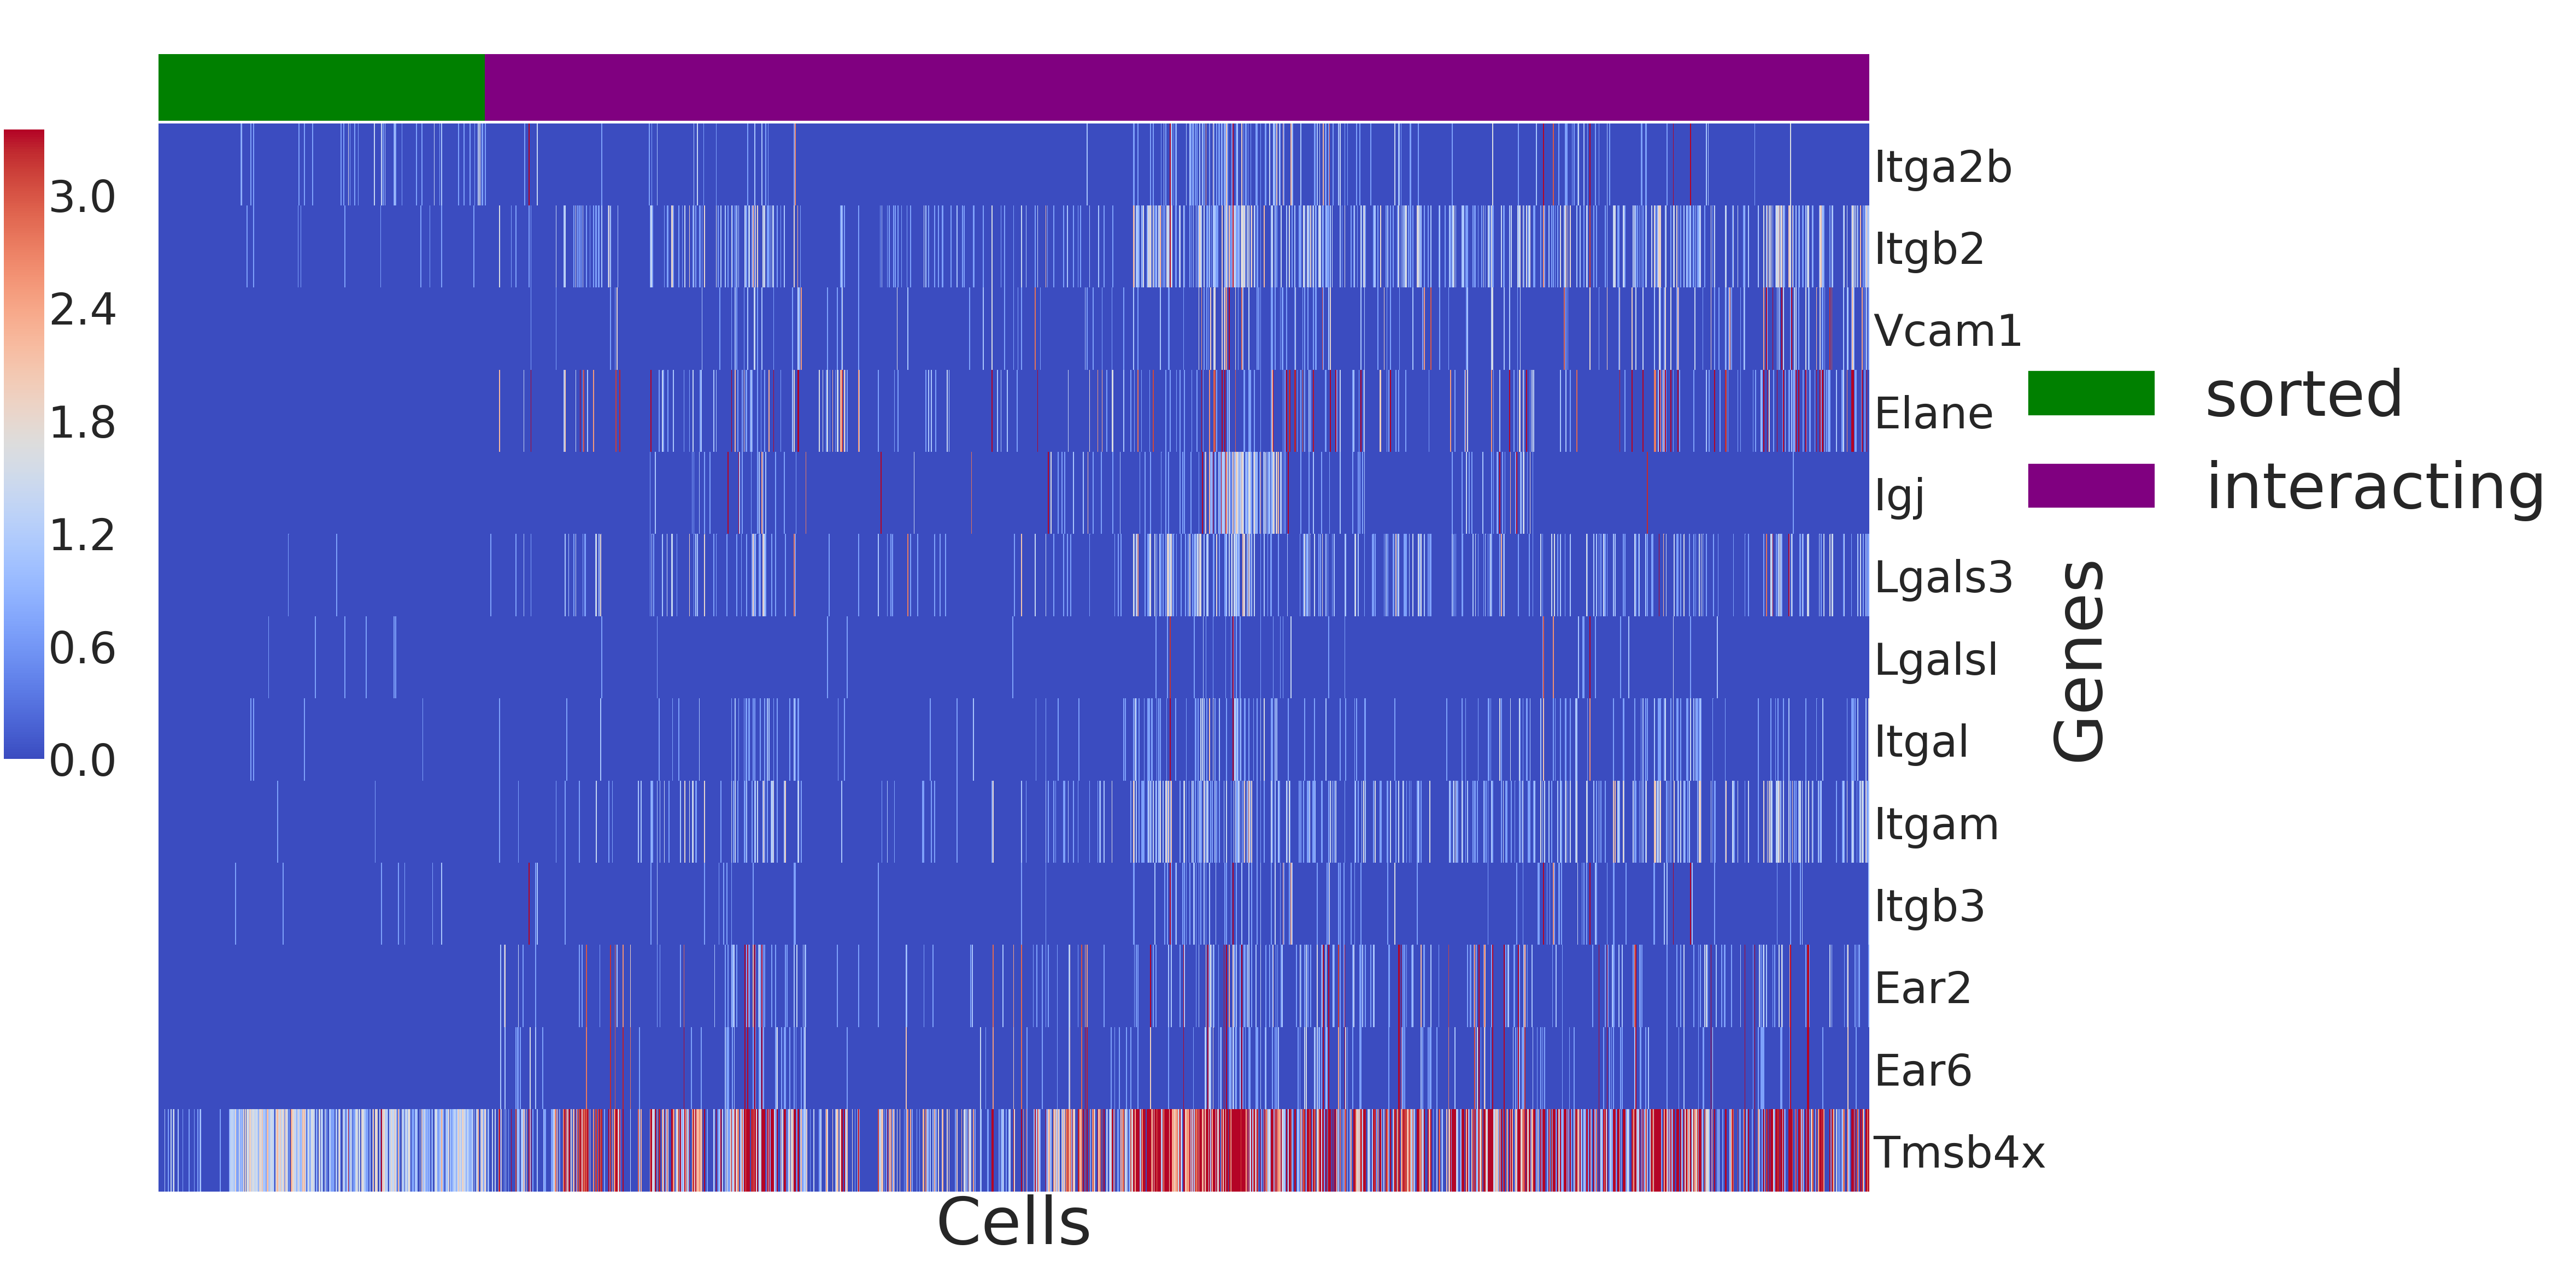

In [376]:
sb.set(font_scale=8)
green_sorted = mpatches.Patch(color="green", label="sorted")
purple_dissected = mpatches.Patch(color="purple", label='interacting')
legend_TN = [green_sorted, purple_dissected]
heatmap1 = sb.clustermap(np.log1p(all_cells.loc[['Itga2b','Itgb2','Vcam1','Elane','Igj',
                                                 'Lgals3','Lgalsl','Itgal','Itgam','Itgb3','Ear2','Ear6','Tmsb4x']]),
                  figsize=(60,40),row_cluster=False, col_cluster=False,
                         robust=True,cmap='coolwarm',col_colors = colours)

heatmap1.ax_heatmap.set_xticks([])
heatmap1.ax_heatmap.set_xlabel("Cells",fontsize=120)
heatmap1.ax_heatmap.set_ylabel("Genes",fontsize=120)
heatmap1.cax.set_position(pos=Bbox(np.array([[0.11,0.4],[0.127,0.8]])))

l2 = heatmap1.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.06,0.70),handles=legend_TN,frameon=False,
                                fontsize="large")

#plt.savefig("Boisset_colorbar.png",bbox_inches='tight')

